In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from data import load_database_train
from preprocessing import InterpolateRawData
from train import grid_search, scikit_train_validate
from sklearn.model_selection import cross_val_score
from cross_validation import cv_folds_author
import numpy as np
from plotter import plot_all_readings


%matplotlib inline

In [5]:
database_train = load_database_train()
X_processed = InterpolateRawData(num_samples=40).fit_transform(database_train.X)

# Modelo Base

## Analisando quantidade de amostragem na interpolação dos dados 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   14.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   21.5s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   37.0s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   52.2s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done  78 out of  80 | elapsed:  7.2min remaining:   11.0s
[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:  7.2min finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'interpolate__num_samples': 5},0.94,0.03,0.65,0.15
1,{'interpolate__num_samples': 10},1.00,0.00,0.65,0.12
2,{'interpolate__num_samples': 20},1.00,0.00,0.68,0.14
3,{'interpolate__num_samples': 40},1.00,0.00,0.71,0.14
4,{'interpolate__num_samples': 80},1.00,0.00,0.70,0.14
5,{'interpolate__num_samples': 120},1.00,0.00,0.70,0.15
6,{'interpolate__num_samples': 240},1.00,0.00,0.70,0.14
7,"{'interpolate__max_time': 6000, 'interpolate__num_samples': None, 'interpolate__timestep': 10}",1.00,0.00,0.49,0.20
8,"{'interpolate__max_time': 6000, 'interpolate__num_samples': None, 'interpolate__timestep': 50}",1.00,0.00,0.48,0.20
9,"{'interpolate__max_time': 6000, 'interpolate__num_samples': None, 'interpolate__timestep': 100}",1.00,0.00,0.46,0.20


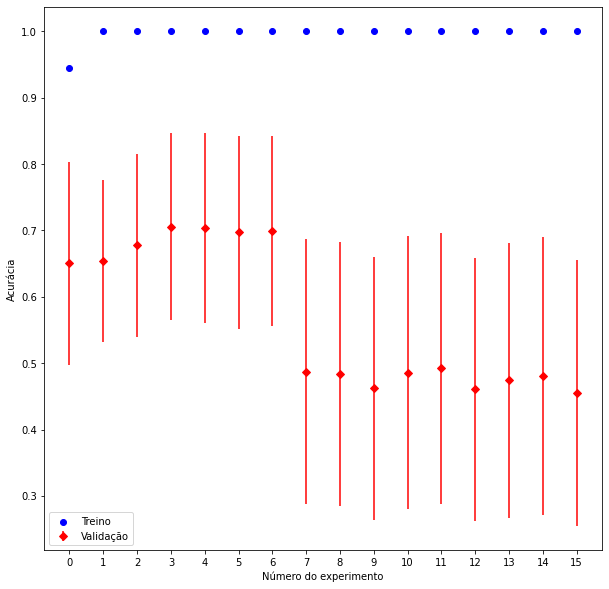

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
3,{'interpolate__num_samples': 40},1.00,0.00,0.71,0.14


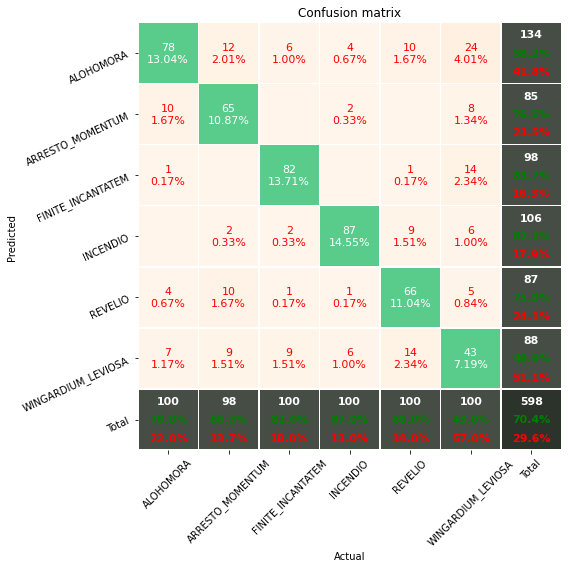

Pipeline(steps=[('interpolate', InterpolateRawData(num_samples=40)),
                ('logistic',
                 LogisticRegression(max_iter=100000, random_state=0))])

In [6]:
pipe = Pipeline([
    ('interpolate', InterpolateRawData()),
    ('logistic', LogisticRegression(random_state=0, max_iter=100000))
])

parameters = [
    {'interpolate__num_samples': [5, 10, 20, 40, 80, 120, 240]},
    
    {'interpolate__num_samples': [None], 
     'interpolate__timestep': [10, 50, 100], 
     'interpolate__max_time': [6000, 5000, 4000] 
    }
]

grid_search(pipe, parameters, database_train.X, database_train.y, database_train.cv_author, n_jobs=6)

Segundo modelo base de **Regressão Logistica**, o num_samples = 80 trouxe bons resultados, e maiores amostragens não trouxeram mudanças significativas. Nosso método grid_search já faz o Kfold considerando como divisaão de dados os autores (**cv_folds_author**)

Olhando os scores abaixo, percebemos como houve muita variação entre os folds, visto que cada fold é um autor com celular diferente que não tem no modelo.

In [7]:
pipe = Pipeline([
    ('logistic', LogisticRegression(random_state=0, max_iter=100000))
])

print(cross_val_score(pipe, X_processed, database_train.y, cv=database_train.cv_author))

[0.49166667 0.80833333 0.875      0.58333333 0.76271186]


Se não usassemos este método, e os dados fossem misturado, o resultado do modelo seria muito enviesado como abaixo, onde manteve uma boa acurácia acima dos 84% em todos os folds

In [8]:
print(cross_val_score(pipe, X_processed, database_train.y, cv=5))

[0.88333333 0.89166667 0.89166667 0.90756303 0.84033613]


# Redes Neurais

### Encontrando melhor learning rate

dict_keys(['memory', 'steps', 'verbose', 'mlp', 'mlp__activation', 'mlp__alpha', 'mlp__batch_size', 'mlp__beta_1', 'mlp__beta_2', 'mlp__early_stopping', 'mlp__epsilon', 'mlp__hidden_layer_sizes', 'mlp__learning_rate', 'mlp__learning_rate_init', 'mlp__max_fun', 'mlp__max_iter', 'mlp__momentum', 'mlp__n_iter_no_change', 'mlp__nesterovs_momentum', 'mlp__power_t', 'mlp__random_state', 'mlp__shuffle', 'mlp__solver', 'mlp__tol', 'mlp__validation_fraction', 'mlp__verbose', 'mlp__warm_start'])
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   31.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   40.8s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  28 out of  35 | elapsed:  1.6min remaining:   24.3s
[Parallel(n_jobs=6)]: Done  32 out of  35 | elapsed:  1.6min remaining:    9.2s
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:  1.7min finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'mlp__learning_rate_init': 0.0001},1.00,0.00,0.74,0.13
1,{'mlp__learning_rate_init': 0.0005},1.00,0.00,0.82,0.17
2,{'mlp__learning_rate_init': 0.001},1.00,0.00,0.82,0.18
3,{'mlp__learning_rate_init': 0.005},0.99,0.01,0.81,0.14
4,{'mlp__learning_rate_init': 0.01},0.97,0.04,0.75,0.17
5,{'mlp__learning_rate_init': 0.05},0.17,0.01,0.17,0.02
6,{'mlp__learning_rate_init': 0.1},0.17,0.00,0.17,0.00


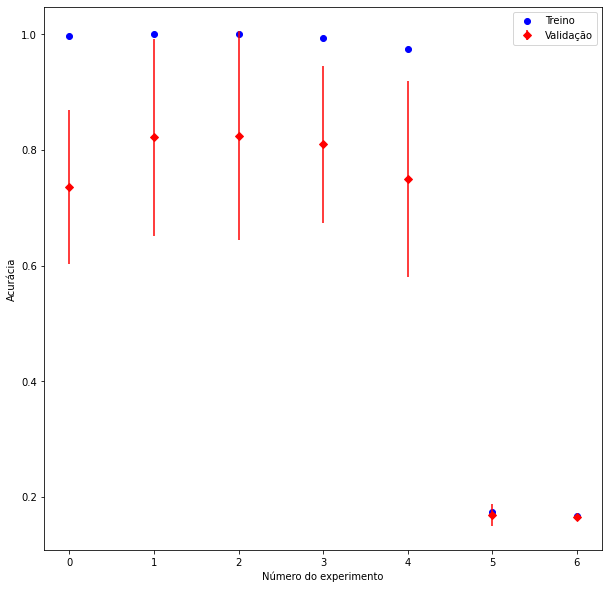

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
2,{'mlp__learning_rate_init': 0.001},1.00,0.00,0.82,0.18


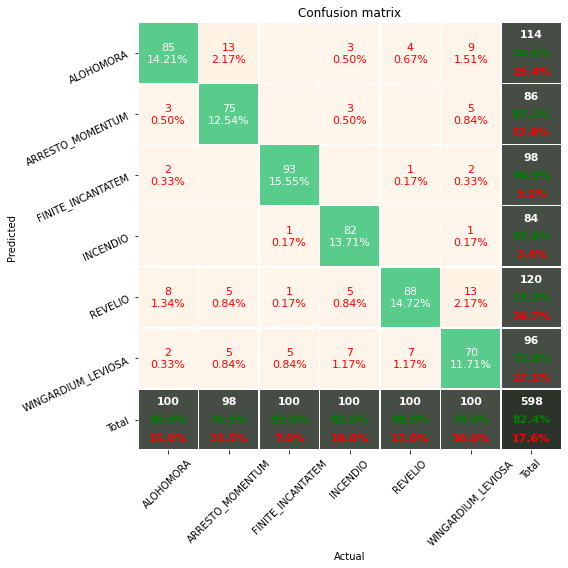

Pipeline(steps=[('mlp',
                 MLPClassifier(hidden_layer_sizes=(100, 10), max_iter=100000,
                               random_state=0))])

In [9]:
pipe = Pipeline([
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, hidden_layer_sizes=(100, 10)))
])

print(pipe.get_params().keys())

parameters = {'mlp__learning_rate_init': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]}
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Vemos que uma tendencia do learning rate baixo, possuir um resultado dinals melhor, apesar das diferenças não significativas para learning_rate < 0.01, vamos adotar 0.0001 como padrão se o mesmo não causar tempo muito grande no aprendizado.

### Testando diferentes funções de ativação

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    5.5s
[Parallel(n_jobs=6)]: Done  12 out of  20 | elapsed:    8.7s remaining:    5.8s
[Parallel(n_jobs=6)]: Done  15 out of  20 | elapsed:   10.5s remaining:    3.5s
[Parallel(n_jobs=6)]: Done  18 out of  20 | elapsed:   11.3s remaining:    1.3s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:   11.6s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'mlp__activation': 'identity'},1.00,0.00,0.73,0.16
1,{'mlp__activation': 'logistic'},1.00,0.00,0.76,0.17
2,{'mlp__activation': 'tanh'},1.00,0.00,0.79,0.15
3,{'mlp__activation': 'relu'},1.00,0.00,0.75,0.17


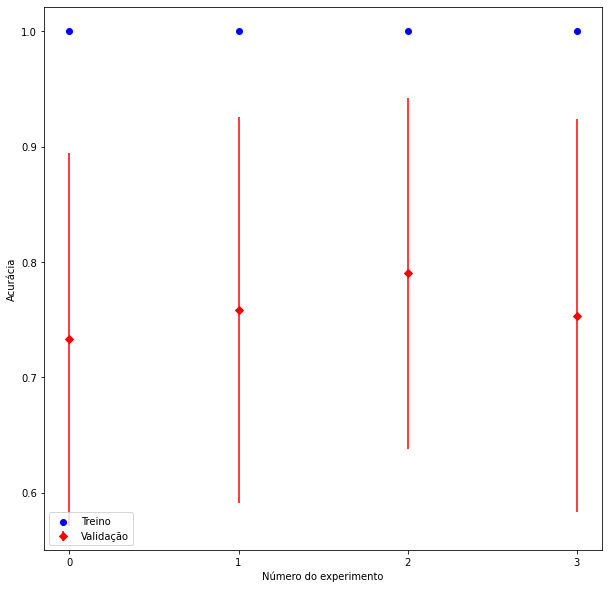

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
2,{'mlp__activation': 'tanh'},1.00,0.00,0.79,0.15


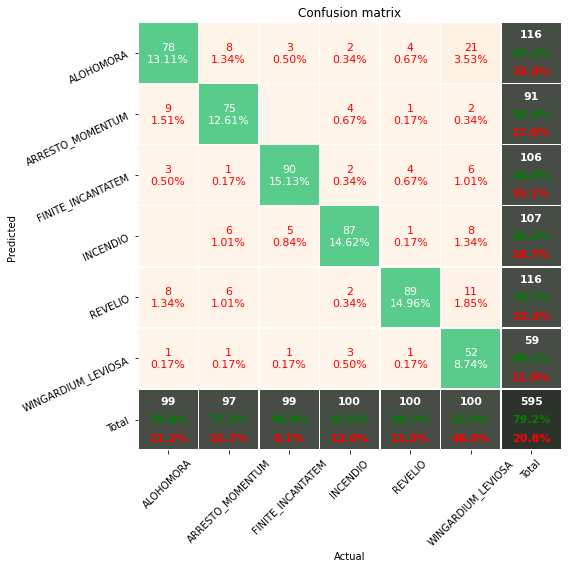

Pipeline(steps=[('mlp',
                 MLPClassifier(activation='tanh', learning_rate_init=0.0001,
                               max_iter=100000, random_state=0))])

In [10]:
pipe = Pipeline([
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001))
])

parameters = {'mlp__activation': ['identity', 'logistic', 'tanh', 'relu']}
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Não conseguimos notar diferenças significaticas na função de ativação, a 'relu' parece ser levemente melhor, vamos adota-la como padrão (já é o padrão da biblioteca)

### Testando diferentes batch-size

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    6.3s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   11.7s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   14.9s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   18.3s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   21.7s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   25.7s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   29.3s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:   34.2s
[Parallel(n_jobs=6)]: Done  95 out of  95 | elapsed:   40.3s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'mlp__batch_size': 10},1.00,0.00,0.76,0.17
1,{'mlp__batch_size': 20},1.00,0.00,0.76,0.17
2,{'mlp__batch_size': 30},1.00,0.00,0.75,0.17
3,{'mlp__batch_size': 40},1.00,0.00,0.75,0.17
4,{'mlp__batch_size': 50},1.00,0.00,0.75,0.17
5,{'mlp__batch_size': 60},1.00,0.00,0.75,0.17
6,{'mlp__batch_size': 70},1.00,0.00,0.75,0.17
7,{'mlp__batch_size': 80},1.00,0.00,0.75,0.17
8,{'mlp__batch_size': 90},1.00,0.00,0.75,0.17
9,{'mlp__batch_size': 100},1.00,0.00,0.75,0.17


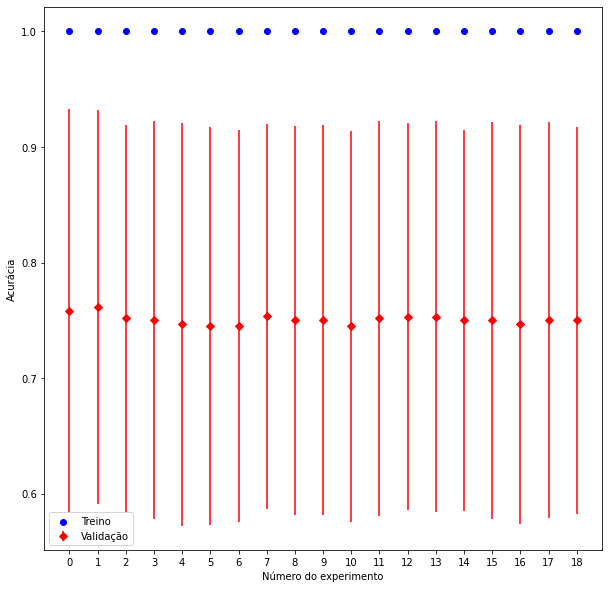

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
1,{'mlp__batch_size': 20},1.00,0.00,0.76,0.17


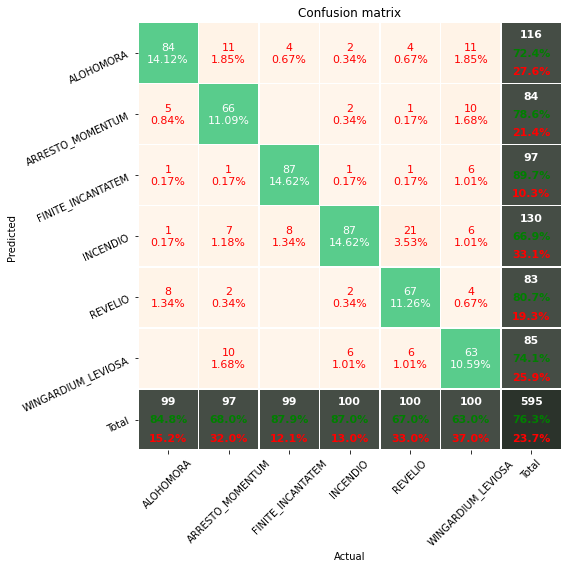

Pipeline(steps=[('mlp',
                 MLPClassifier(batch_size=20, learning_rate_init=0.0001,
                               max_iter=100000, random_state=0))])

In [11]:
pipe = Pipeline([
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001))
])

parameters = {'mlp__batch_size': np.arange(10, 200, 10)}
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Sem diferenças no batch-size, vamos usar o padrao do scikit-learn que é 200

### Testando Scalers

train_scores:     ['1.00', '1.00', '1.00', '1.00', '1.00'] 
mean_train_score: 1.00
std_train_score:  0.00


test_scores:      ['0.82', '0.42', '0.93', '0.81', '0.75']
mean_test_score:  0.75
std_test_score:   0.17


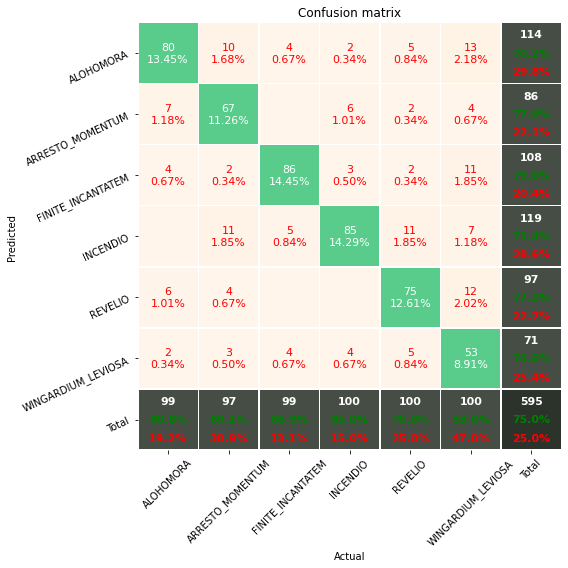

In [12]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001))
])

scikit_train_validate(pipe, X_processed, database_train.y, database_train.cv_author)

train_scores:     ['1.00', '1.00', '1.00', '1.00', '1.00'] 
mean_train_score: 1.00
std_train_score:  0.00


test_scores:      ['0.84', '0.42', '0.94', '0.78', '0.72']
mean_test_score:  0.74
std_test_score:   0.18


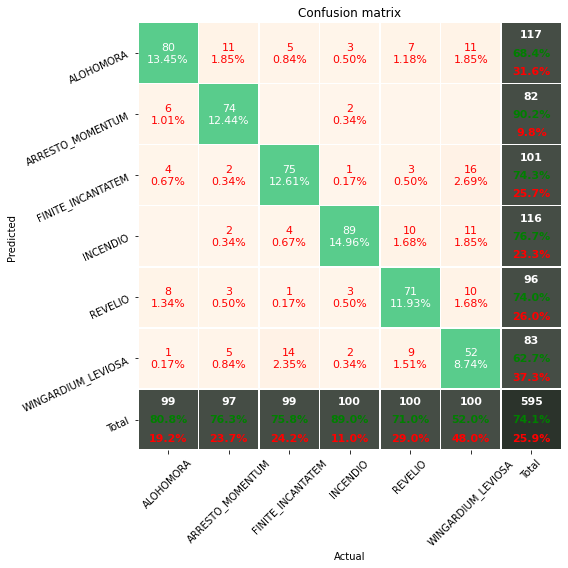

In [13]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001))
])

scikit_train_validate(pipe, X_processed, database_train.y, database_train.cv_author)

Vemos que o método StandardScaler, melhorou razoavelmente o modelo, isso pode ser explicado pois dados do Giroscopio e Acelerometro não estão na mesma escala, como pode ser visto nesse exemplo:

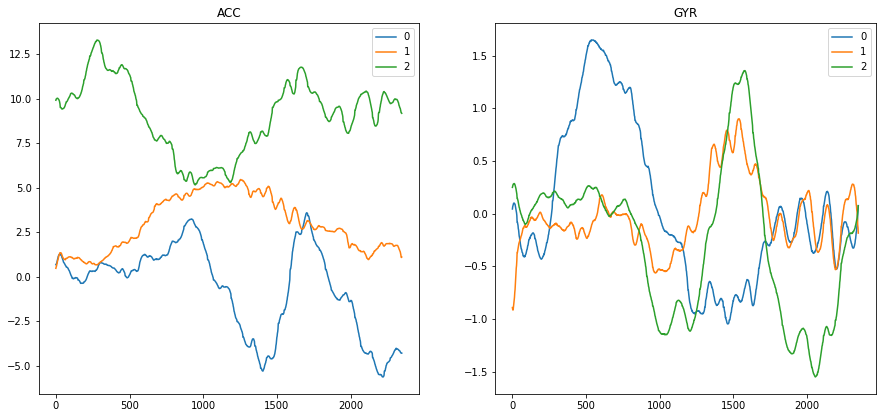

In [14]:
plot_all_readings(database_train.datalist[0].readings, table_format=(0, 2))

### Testando regularização l2

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    7.2s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   16.4s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   23.1s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   30.7s
[Parallel(n_jobs=6)]: Done  39 out of  45 | elapsed:   42.2s remaining:    6.5s
[Parallel(n_jobs=6)]: Done  45 out of  45 | elapsed:   46.9s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'mlp__alpha': 1},1.00,0.00,0.77,0.18
1,{'mlp__alpha': 10},1.00,0.00,0.79,0.18
2,{'mlp__alpha': 50},0.91,0.03,0.79,0.18
3,{'mlp__alpha': 60},0.90,0.04,0.78,0.18
4,{'mlp__alpha': 70},0.89,0.04,0.77,0.18
5,{'mlp__alpha': 80},0.88,0.04,0.77,0.18
6,{'mlp__alpha': 100},0.85,0.06,0.74,0.16
7,{'mlp__alpha': 150},0.72,0.08,0.61,0.11
8,{'mlp__alpha': 200},0.61,0.08,0.57,0.10


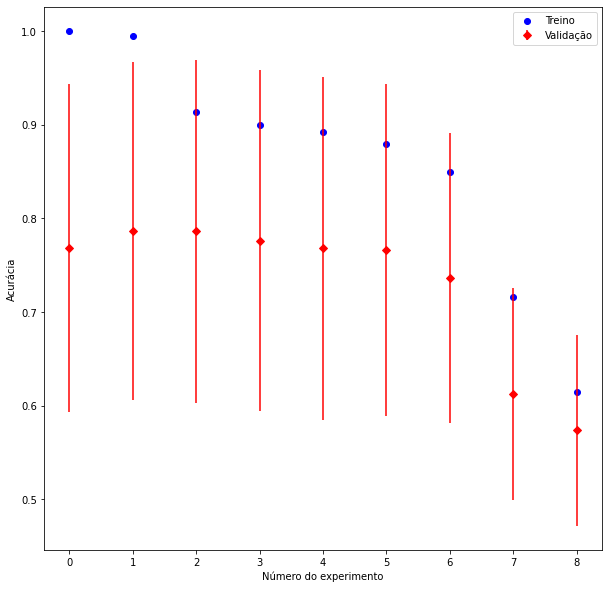

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
1,{'mlp__alpha': 10},1.00,0.00,0.79,0.18


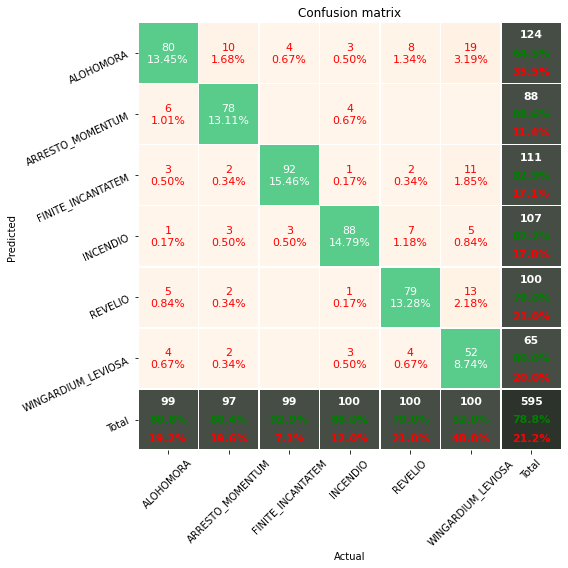

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(alpha=10, learning_rate_init=0.0001,
                               max_iter=100000, random_state=0))])

In [16]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001))
])

parameters = {'mlp__alpha': [1, 10, 50, 60, 70, 80, 100, 150, 200]}

grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Vimos que agora um alpha de 60 melhorou suavemente o modelo na validação e deixou com menos overfit

### Early-stop

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   12.8s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   20.9s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   33.3s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   48.1s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  95 out of  95 | elapsed:  2.3min finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'mlp__n_iter_no_change': 100},0.84,0.07,0.65,0.19
1,{'mlp__n_iter_no_change': 200},0.86,0.06,0.67,0.20
2,{'mlp__n_iter_no_change': 300},0.86,0.06,0.68,0.21
3,{'mlp__n_iter_no_change': 400},0.88,0.03,0.74,0.19
4,{'mlp__n_iter_no_change': 500},0.88,0.03,0.74,0.19
5,{'mlp__n_iter_no_change': 600},0.88,0.03,0.74,0.19
6,{'mlp__n_iter_no_change': 700},0.88,0.03,0.74,0.19
7,{'mlp__n_iter_no_change': 800},0.88,0.03,0.74,0.19
8,{'mlp__n_iter_no_change': 900},0.88,0.03,0.74,0.19
9,{'mlp__n_iter_no_change': 1000},0.88,0.03,0.74,0.19


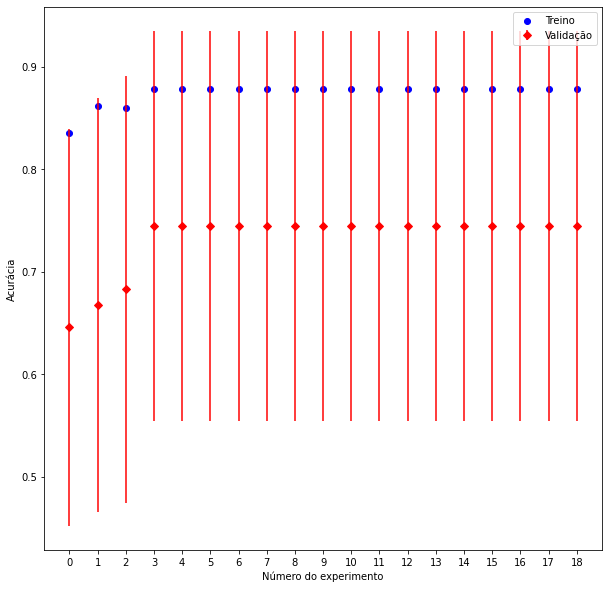

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
3,{'mlp__n_iter_no_change': 400},0.88,0.03,0.74,0.19


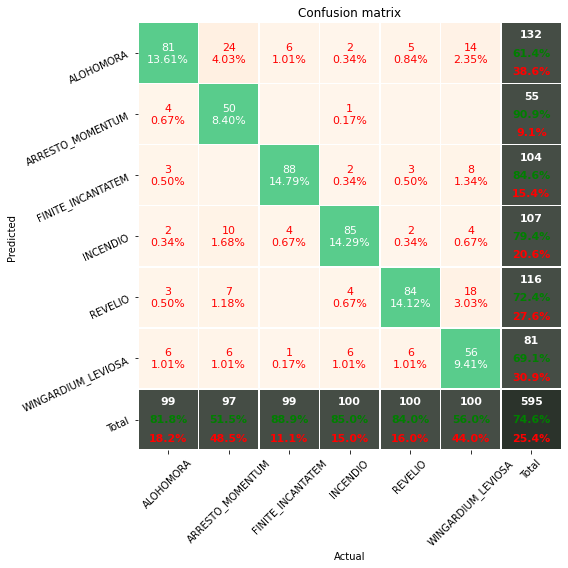

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(alpha=60, early_stopping=True,
                               learning_rate_init=0.0001, max_iter=100000,
                               n_iter_no_change=400, random_state=0))])

In [17]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001,
                          alpha=60, early_stopping=True))
])

parameters = {'mlp__n_iter_no_change': np.arange(100, 2000, 100)}

grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Vimos que o método early_stopping não trouxe beneficios ao modelo.

### Numero de neuronios

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done  12 out of  20 | elapsed:   36.0s remaining:   24.0s
[Parallel(n_jobs=6)]: Done  15 out of  20 | elapsed:   40.3s remaining:   13.4s
[Parallel(n_jobs=6)]: Done  18 out of  20 | elapsed:  1.2min remaining:    7.9s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  1.2min finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,"{'mlp__hidden_layer_sizes': (10,)}",0.90,0.04,0.75,0.16
1,"{'mlp__hidden_layer_sizes': (100,)}",0.90,0.04,0.78,0.18
2,"{'mlp__hidden_layer_sizes': (500,)}",0.90,0.04,0.78,0.19
3,"{'mlp__hidden_layer_sizes': (1000,)}",0.90,0.04,0.77,0.18


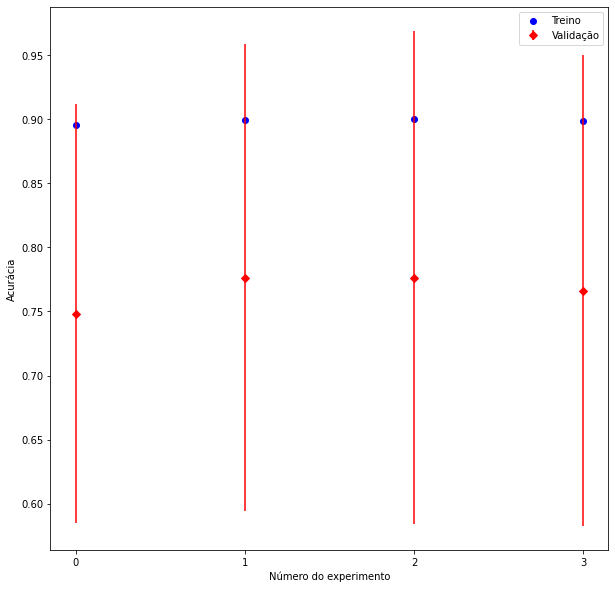

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
1,"{'mlp__hidden_layer_sizes': (100,)}",0.90,0.04,0.78,0.18


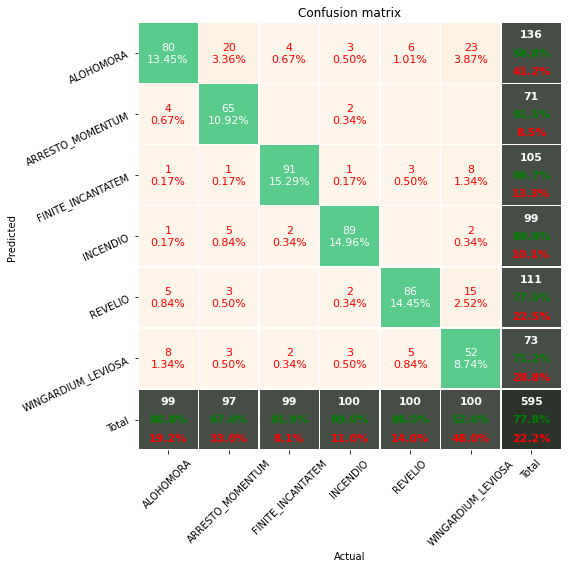

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(alpha=60, learning_rate_init=0.0001,
                               max_iter=100000, random_state=0))])

In [18]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001, alpha=60))
])
 
parameters = {'mlp__hidden_layer_sizes': [(10,), (100,), (500,), (1000,)]}
 
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    5.2s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   18.2s
[Parallel(n_jobs=6)]: Done  23 out of  30 | elapsed:   31.2s remaining:    9.5s
[Parallel(n_jobs=6)]: Done  27 out of  30 | elapsed:   44.2s remaining:    4.9s
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   46.2s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,"{'mlp__hidden_layer_sizes': (50,)}",0.90,0.04,0.78,0.18
1,"{'mlp__hidden_layer_sizes': (100,)}",0.90,0.04,0.78,0.18
2,"{'mlp__hidden_layer_sizes': (200,)}",0.90,0.04,0.77,0.18
3,"{'mlp__hidden_layer_sizes': (50, 10)}",0.52,0.19,0.42,0.13
4,"{'mlp__hidden_layer_sizes': (100, 20)}",0.50,0.22,0.40,0.16
5,"{'mlp__hidden_layer_sizes': (200, 40)}",0.49,0.21,0.35,0.08


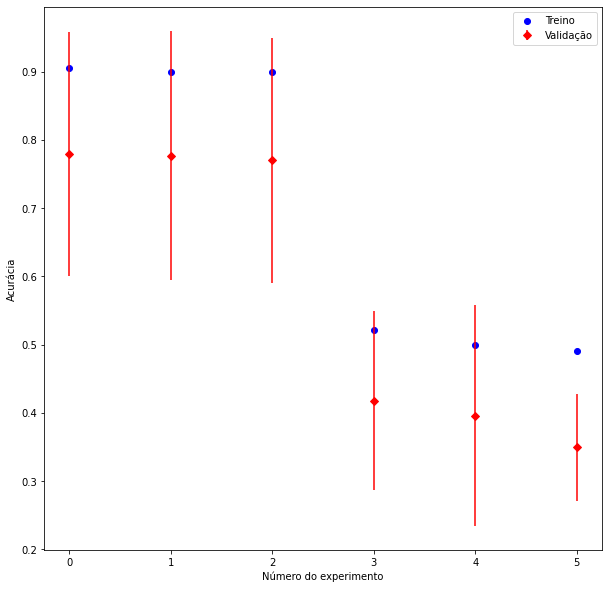

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,"{'mlp__hidden_layer_sizes': (50,)}",0.90,0.04,0.78,0.18


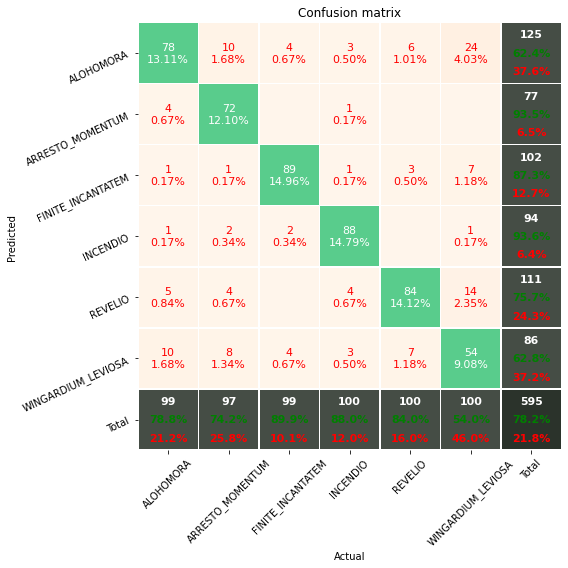

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(alpha=60, hidden_layer_sizes=(50,),
                               learning_rate_init=0.0001, max_iter=100000,
                               random_state=0))])

In [19]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001, alpha=60))
])
 
parameters = {'mlp__hidden_layer_sizes': [(50,), (100,), (200,), (50, 10), (100, 20), (200, 40)]}
 
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    7.1s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   20.1s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   29.9s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   46.1s
[Parallel(n_jobs=6)]: Done  39 out of  45 | elapsed:  1.1min remaining:    9.8s
[Parallel(n_jobs=6)]: Done  45 out of  45 | elapsed:  1.3min finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,"{'mlp__alpha': 1, 'mlp__hidden_layer_sizes': (50, 10)}",1.00,0.00,0.77,0.16
1,"{'mlp__alpha': 1, 'mlp__hidden_layer_sizes': (100, 20)}",1.00,0.00,0.77,0.16
2,"{'mlp__alpha': 1, 'mlp__hidden_layer_sizes': (200, 40)}",1.00,0.00,0.78,0.17
3,"{'mlp__alpha': 10, 'mlp__hidden_layer_sizes': (50, 10)}",0.99,0.00,0.77,0.17
4,"{'mlp__alpha': 10, 'mlp__hidden_layer_sizes': (100, 20)}",0.99,0.00,0.77,0.17
5,"{'mlp__alpha': 10, 'mlp__hidden_layer_sizes': (200, 40)}",0.99,0.00,0.79,0.18
6,"{'mlp__alpha': 60, 'mlp__hidden_layer_sizes': (50, 10)}",0.52,0.19,0.42,0.13
7,"{'mlp__alpha': 60, 'mlp__hidden_layer_sizes': (100, 20)}",0.50,0.22,0.40,0.16
8,"{'mlp__alpha': 60, 'mlp__hidden_layer_sizes': (200, 40)}",0.49,0.21,0.35,0.08


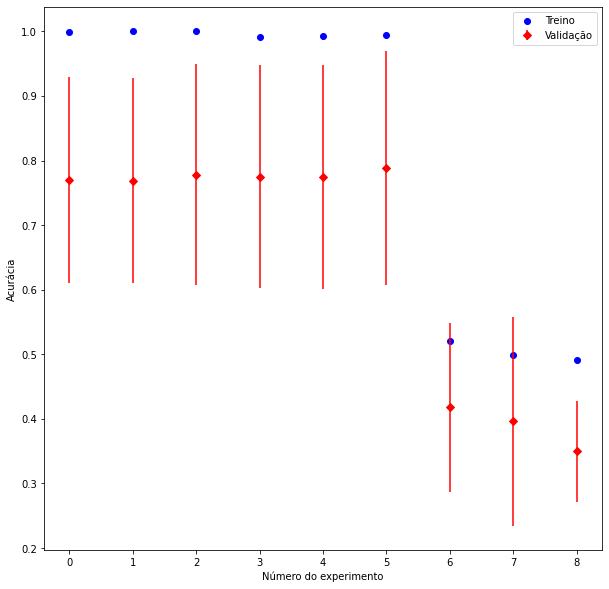

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
5,"{'mlp__alpha': 10, 'mlp__hidden_layer_sizes': (200, 40)}",0.99,0.00,0.79,0.18


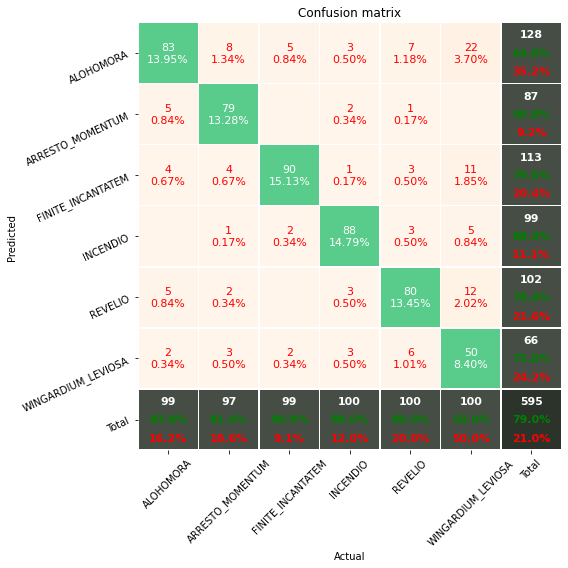

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(alpha=10, hidden_layer_sizes=(200, 40),
                               learning_rate_init=0.0001, max_iter=100000,
                               random_state=0))])

In [20]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001, alpha=60))
])
 
parameters = {
    'mlp__alpha': [1, 10, 60],
    'mlp__hidden_layer_sizes': [(50, 10), (100, 20), (200, 40)]}
 
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Aparentemete as redes neurais ficaram piores com o aumento do numero de camadas